In [2]:
import numpy as np
import tensorflow as tf

#tf.enable_eager_execution()
#tf.random.set_random_seed(42)
np.random.seed(42)

import tensorflow.keras as K

from tensorflow_probability import distributions as tfd

from tensorflow.keras.layers import Input, Dense, Activation, Concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
# Example presented in the PRML book
def create_book_example(n=1000):
    # sample uniformly over the interval (0,1)
    X = np.random.uniform(0., 1., (n,1)).astype(np.float32)    
    # target values 
    y = X + 0.3 * np.sin(2 * np.pi * X) + np.random.uniform(-0.1, 0.1, size=(n,1)).astype(np.float32)
    # test data
    x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)    
    return X, y, x_test

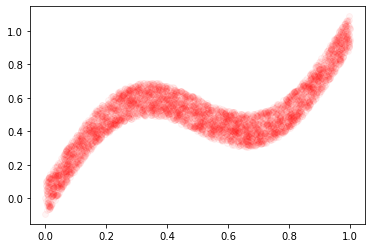

In [4]:
# Plot data (x and y)
X, y, x_test = create_book_example(n=4000)
plt.plot(X, y, 'ro', alpha=0.04)
plt.show()

In [5]:
from copy import deepcopy
print(X.shape, y.shape)

# Deepcopy is not required in this case
# (its more of a habit for me)
flipped_x = deepcopy(y)
flipped_y = deepcopy(X)


flipped_x = np.hstack([flipped_x, flipped_x + .5, flipped_x - .5])

flipped_y = np.hstack([flipped_y, flipped_y])

print(flipped_x.shape)
print(flipped_y.shape)


(4000, 1) (4000, 1)
(4000, 3)
(4000, 2)


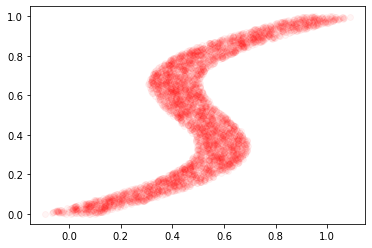

In [6]:
plt.plot(flipped_x[:,0], flipped_y[:,0], 'ro', alpha=0.04)

In [13]:
class MDN(tf.keras.Model):

    def __init__(self, neurons=100, components=2, num_output=1):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
                
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.alphas      = Dense(components, activation="softmax", name="alphas")
        self.mus         = Dense(components, name="mus")
        self.sigmas      = Dense(components, activation="nnelu", name="sigmas")
        self.pvec        = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])


In [14]:
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    
    alphas = parameter_vector[:, :components]
#     mus    = parameter_vector[:, components:components+components*num_output]
#     sigmas = parameter_vector[:, components+components*num_output:]

    mus = parameter_vector[:, components:2*components]
    sigmas = parameter_vector[:, 2*components:]
    
    
    #assert mus.shape[1] == components*num_output
    #mus    = tf.reshape(mus,   (-1, num_output, components))
    #sigmas = tf.reshape(sigmas,(-1, num_output, components) )
    
    print('---')
    print(alphas.shape)
    print(mus.shape)
    print(sigmas.shape)    
    print('----')
    
    return [alphas, mus, sigmas]
    
    
    
    
    
def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    
    
    print('******', mu.shape)
    
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    print('****** 1',)
    
    log_likelihood = gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y
    
    print('****** 2',)
    loss =  -tf.reduce_mean(log_likelihood, axis=-1)

    print('****** 3',)
    return loss
    
tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

In [9]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[.3, .5, .2]),
    components_distribution=tfd.Normal(
        loc=[[1,2,3], [4,5,7]],       
        scale=[[4,4,5],[4,4,6]]))

        

In [10]:
num_output

NameError: name 'num_output' is not defined

In [15]:
no_parameters = 3
components = 3
num_output = flipped_y.shape[1]

mdn = MDN(neurons=100, components=components, num_output=num_output)
mdn.compile(loss=gnll_loss, optimizer=tf.optimizers.Adam(learning_rate=10e-3))

In [16]:
mdn.fit(flipped_x, flipped_y, epochs=100, verbose=1)

Epoch 1/100
---
(32, 3)
(32, 3)
(32, 3)
----
****** (32, 3)
****** 1
****** 2
****** 3
---
(32, 3)
(32, 3)
(32, 3)
----
****** (32, 3)
****** 1
****** 2
****** 3
125/125 [==============================] - 0s 755us/step - loss: -0.0095
Epoch 2/100
125/125 [==============================] - 0s 849us/step - loss: -0.1471
Epoch 3/100
125/125 [==============================] - 0s 773us/step - loss: -0.3381
Epoch 4/100
125/125 [==============================] - 0s 769us/step - loss: -0.5480
Epoch 5/100
125/125 [==============================] - 0s 919us/step - loss: -0.3939
Epoch 6/100
125/125 [==============================] - 0s 894us/step - loss: -0.7505
Epoch 7/100
125/125 [==============================] - 0s 1ms/step - loss: -0.8295
Epoch 8/100
125/125 [==============================] - 0s 804us/step - loss: -0.8947
Epoch 9/100
125/125 [==============================] - 0s 759us/step - loss: -0.9659
Epoch 10/100
125/125 [==============================] - 0s 718us/step - loss: -0.9229
E

125/125 [==============================] - 0s 726us/step - loss: -1.0671
Epoch 95/100
125/125 [==============================] - 0s 730us/step - loss: -1.0658
Epoch 96/100
125/125 [==============================] - 0s 753us/step - loss: -1.0594
Epoch 97/100
125/125 [==============================] - 0s 749us/step - loss: -1.0848
Epoch 98/100
125/125 [==============================] - 0s 731us/step - loss: -1.0893
Epoch 99/100
125/125 [==============================] - 0s 710us/step - loss: -1.0767
Epoch 100/100
125/125 [==============================] - 0s 707us/step - loss: -1.0595


In [17]:
x_range = np.linspace(flipped_x.min(), flipped_x.max(), num=150).reshape((150,1))


x_range = np.hstack([x_range, x_range +0.5, x_range - 0.5])


y_pred = mdn.predict(x_range)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)



print(mu_pred.shape)

---
(150, 3)
(150, 3)
(150, 3)
----
(150, 3)


(1.1634755537670571e-05, 0.999717652797699)

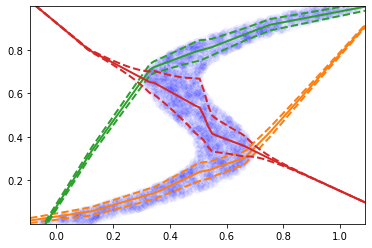

In [19]:
plt.plot(flipped_x[:,0], flipped_y, 'bo', alpha=0.01)

for mx in range(components):
    plt.plot(x_range[:,0], mu_pred[:,mx],                  color=sns.color_palette()[1+mx], linewidth=2, linestyle='-')
    plt.plot(x_range[:,0], mu_pred[:,mx]-sigma_pred[:,mx], color=sns.color_palette()[1+mx], linewidth=2, linestyle='--', markersize=3)
    plt.plot(x_range[:,0], mu_pred[:,mx]+sigma_pred[:,mx], color=sns.color_palette()[1+mx], linewidth=2, linestyle='--', markersize=3)
    
    
plt.xlim([flipped_x[:,0].min(), flipped_x[:,0].max()])
plt.ylim([flipped_y[:,0].min(), flipped_y[:,0].max()])  

(1.1634755537670571e-05, 0.999717652797699)

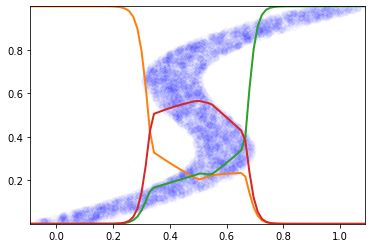

In [21]:
plt.plot(flipped_x[:,0], flipped_y, 'bo', alpha=0.01)

for mx in range(components):
    plt.plot(x_range[:,0],alpha_pred[:,mx], color=sns.color_palette()[1+mx], linewidth=2, linestyle='-')
    
    
plt.xlim([flipped_x[:,0].min(), flipped_x[:,0].max()])
plt.ylim([flipped_y[:,0].min(), flipped_y[:,0].max()])  

In [22]:
def predict_strongest_component(mdn_model, X):
    y_pred                          = mdn_model.predict(X)
    alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)
    strongest_components            = np.argmax(alpha_pred, axis=1)
    predictions                     = mu_pred[np.arange(X.shape[0]),strongest_components]
    return predictions
    
y_best = predict_strongest_component(mdn, x_range)

---
(150, 3)
(150, 3)
(150, 3)
----


(1.1634755537670571e-05, 0.999717652797699)

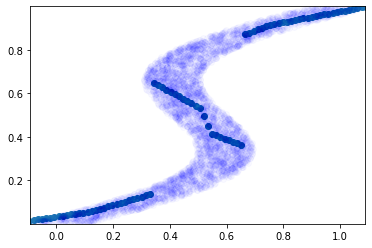

In [24]:
plt.plot(flipped_x[:,0], flipped_y, 'bo', alpha=0.01)
plt.scatter(x_range[:,0],y_best)

plt.xlim([flipped_x[:,0].min(), flipped_x[:,0].max()])
plt.ylim([flipped_y[:,0].min(), flipped_y[:,0].max()])  

----------------------------------
## Repeat with an Overestimation of the components

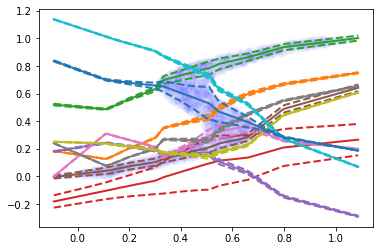

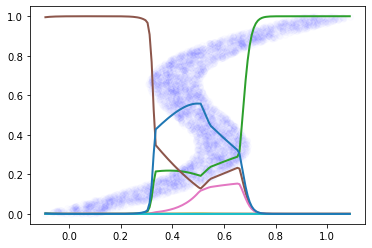

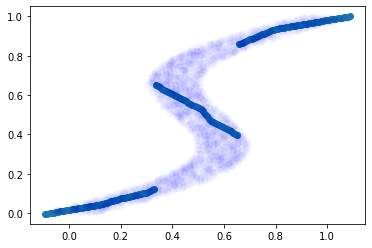

In [88]:
no_parameters = 3
components = 10

mdn = MDN(neurons=100, components=components)
mdn.compile(loss=gnll_loss, optimizer=tf.optimizers.Adam(learning_rate=10e-3))

mdn.fit(flipped_x, flipped_y, epochs=100, verbose=0)

x_range = np.linspace(flipped_x.min(), flipped_x.max(), num=150).reshape((150,1))
y_pred = mdn.predict(x_range)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)


plt.figure()
plt.plot(flipped_x, flipped_y, 'bo', alpha=0.01)
for mx in range(components):
    plt.plot(x_range,mu_pred[:,mx],                  color=sns.color_palette(n_colors=components+1)[1+mx], linewidth=2, linestyle='-')
    plt.plot(x_range,mu_pred[:,mx]-sigma_pred[:,mx], color=sns.color_palette(n_colors=components+1)[1+mx], linewidth=2, linestyle='--', markersize=3)
    plt.plot(x_range,mu_pred[:,mx]+sigma_pred[:,mx], color=sns.color_palette(n_colors=components+1)[1+mx], linewidth=2, linestyle='--', markersize=3)
plt.show()
    
plt.figure()
plt.plot(flipped_x, flipped_y, 'bo', alpha=0.01)
for mx in range(components):
    plt.plot(x_range,alpha_pred[:,mx], color=sns.color_palette(n_colors=components+1)[1+mx], linewidth=2, linestyle='-')
plt.show()

y_best = predict_strongest_component(mdn, x_range)
plt.figure()
plt.plot(flipped_x, flipped_y, 'bo', alpha=0.01)
plt.scatter(x_range,y_best)
plt.show()